# Benchmark

## Problem Size Generation

In [2]:
import random

def generate_problem_sizes(n, min_number = 1, max_number = 1 << 60, sort=False, file_name='problem_size.txt'):
    problem_sizes = [random.randint(min_number, max_number) for _ in range(n)]
    
    if sort:
        problem_sizes.sort()
    
    problem_sizes_str = ';'.join(map(str, problem_sizes))
    with open(file_name, 'w') as f:
        f.write(f'{n}\n')
        f.write(problem_sizes_str)
        
    return problem_sizes

_ = generate_problem_sizes(1_000_000, sort=False)

## Utility Functions

In [3]:
import subprocess
import time
import psutil

def execute_and_monitor(command: str, cwd=None, interval=0.5):
    # Start the process
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, cwd=cwd)

    # Monitor memory and time
    start_time = time.time()
    memory_usage_series = []
    timestamp = 0
    try:
        while True:
            # Check if process has ended and get memory usage
            status = psutil.Process(process.pid)
            memory_use = status.memory_info().rss  # rss = Resident Set Size
            
            if process.poll() is not None:  # If process has finished
                break

            memory_usage_series.append((timestamp, memory_use))
            timestamp += 1
            time.sleep(interval)  # Wait a little before checking again
    except psutil.NoSuchProcess:
        pass
    end_time = time.time()

    result = {
        'command': command,
        'execution_time': end_time - start_time,
        'memory_usage_series': memory_usage_series
    }

    return result

## Runtime Evaluation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

N = 25
work_dirs = ["./cpp", "./java", "./python"]

data_list = []

for i in range(0, N):
    for work_dir in work_dirs:
        data = execute_and_monitor("make run", work_dir, interval=0.1)
        for ts, memory_usage in data['memory_usage_series']:
            data_list.append({
                'Iteration': i,
                'Language': work_dir[2:],
                'Time': ts, 
                'Memory Usage': memory_usage, 
                'Execution Time': data['execution_time']
            })

# Convert the list of dictionaries to a DataFrame
benchmark_df = pd.DataFrame(data_list, columns=['Iteration', 'Language', 'Time', 'Memory Usage', 'Execution Time'])
display(benchmark_df)

,Iteration,Language,Time,Memory Usage,Execution Time
0,0,cpp,0,1007616,0.202296
1,0,cpp,1,1007616,0.202296
2,0,java,0,974848,2.629848
3,0,java,1,974848,2.629848
4,0,java,2,974848,2.629848
...,...,...,...,...,...
9022,24,python,400,991232,41.113780
9023,24,python,401,991232,41.113780
9024,24,python,402,991232,41.113780
9025,24,python,403,991232,41.113780


### Execution Time

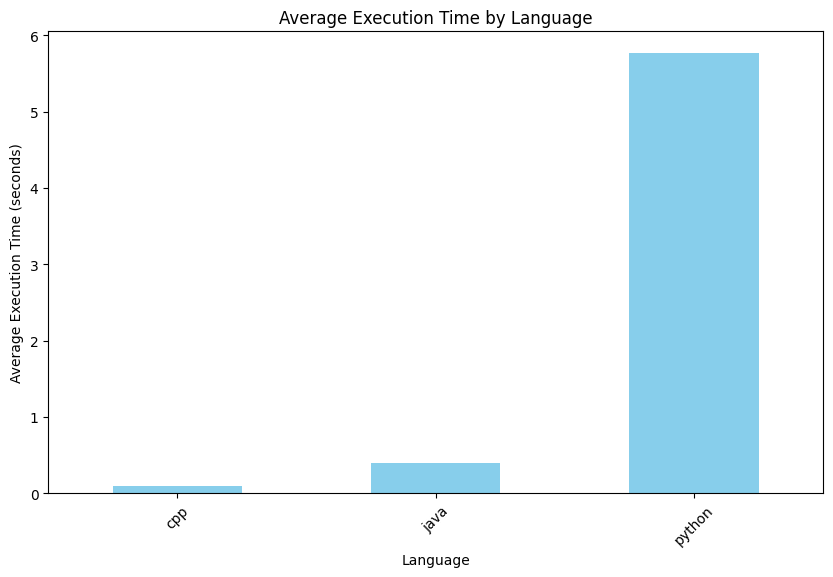

In [18]:
def show_execution_time(df: pd.DataFrame):
    avg_execution_time_per_language = df.groupby('Language')['Execution Time'].mean()
    plt.figure(figsize=(10, 6))
    avg_execution_time_per_language.plot(kind='bar', color='skyblue')
    plt.title('Average Execution Time by Language')
    plt.xlabel('Language')
    plt.ylabel('Average Execution Time (seconds)')
    plt.xticks(rotation=45)
    plt.show()

show_execution_time(benchmark_df)

### Memory Usage

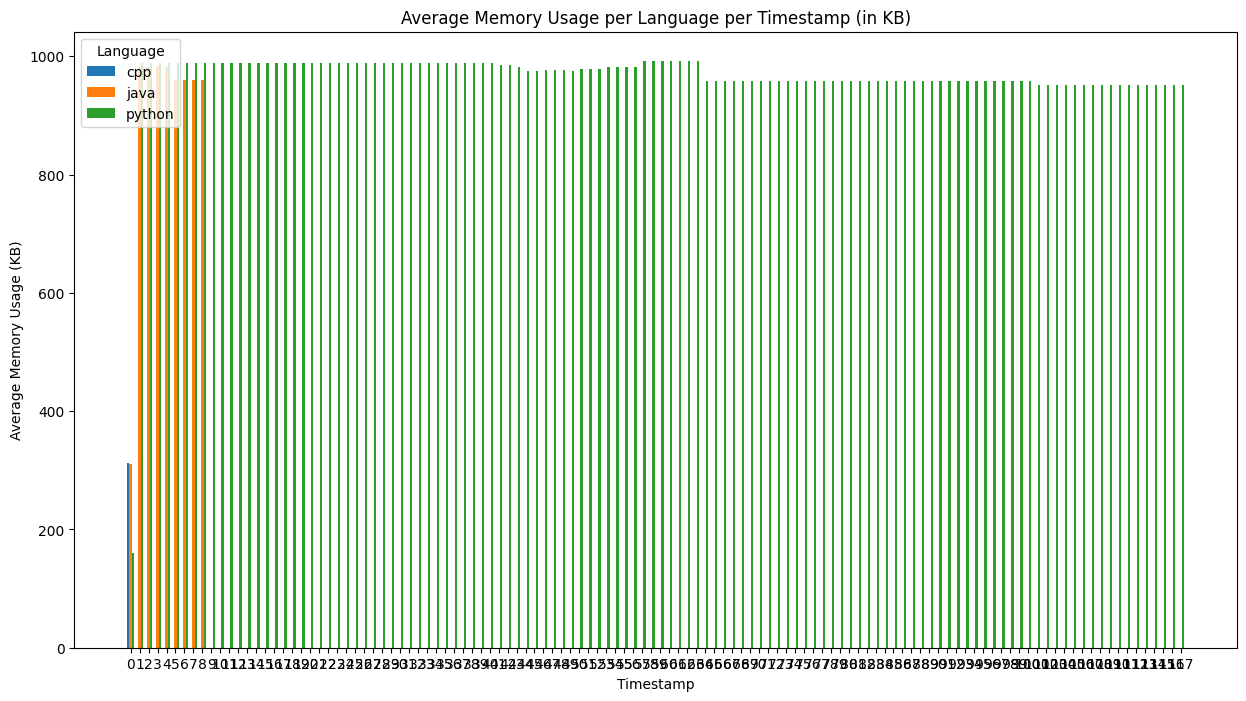

In [13]:
def show_memory_usage(df: pd.DataFrame):
    # Calculating the average memory usage over iteration per language per timestamp
    avg_memory_usage = df.groupby(['Language', 'Time'])['Memory Usage'].mean().unstack(level=0)
    
    avg_memory_usage_kb = avg_memory_usage / 1024  # Convert each value to MB
    grouped_data = avg_memory_usage_kb.reset_index()
    
    # Setting the positions for the bars
    bar_width = 0.25
    positions = list(range(len(grouped_data['Time'])))
    
    plt.figure(figsize=(15, 8))
    
    # Plotting bars for each language
    for i, language in enumerate(grouped_data.columns[1:]):
        plt.bar([p + bar_width*i for p in positions], 
                grouped_data[language], 
                width=bar_width, 
                label=language)
    
    # Adjusting the x-axis to show time labels
    plt.xticks([p + bar_width for p in positions], grouped_data['Time'])
    
    plt.title('Average Memory Usage per Language per Timestamp (in KB)')
    plt.xlabel('Timestamp')
    plt.ylabel('Average Memory Usage (KB)')
    plt.legend(title='Language')
    plt.show()

show_memory_usage(benchmark_df)

## Run and Compile time Evaluation

In [16]:
data_rc_list = []

for i in range(0, N):
    for work_dir in work_dirs:
        data = execute_and_monitor("make compile-run", work_dir, interval=0.1)
        for ts, memory_usage in data['memory_usage_series']:
            data_rc_list.append({
                'Iteration': i,
                'Language': work_dir[2:],
                'Time': ts, 
                'Memory Usage': memory_usage, 
                'Execution Time': data['execution_time']
            })

benchmark_rc_df = pd.DataFrame(data_rc_list, columns=['Iteration', 'Language', 'Time', 'Memory Usage', 'Execution Time'])

### Execution Time

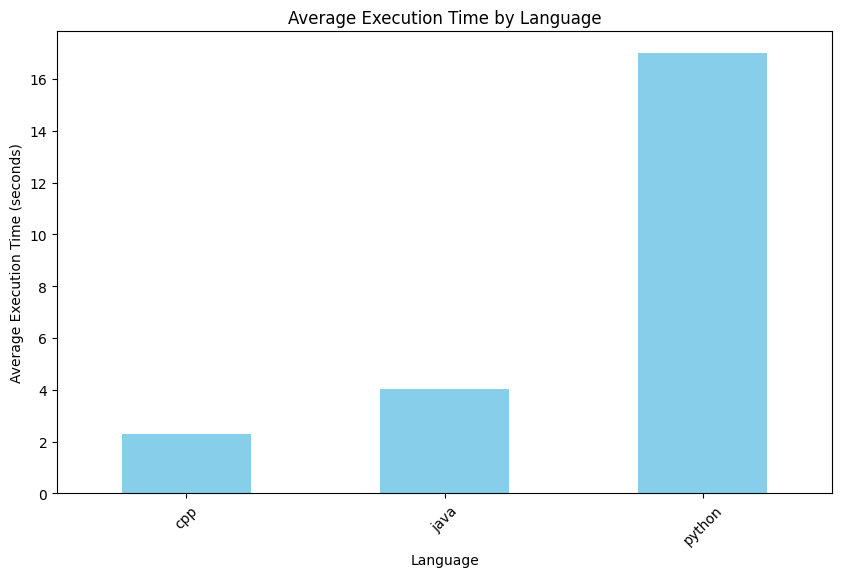

,Iteration,Language,Time,Memory Usage,Execution Time
0,0,cpp,0,4096,3.934325
1,0,cpp,1,974848,3.934325
2,0,cpp,2,974848,3.934325
3,0,cpp,3,974848,3.934325
4,0,cpp,4,974848,3.934325
...,...,...,...,...,...
4653,24,python,154,1081344,16.038838
4654,24,python,155,1081344,16.038838
4655,24,python,156,1081344,16.038838
4656,24,python,157,1081344,16.038838


In [19]:
show_execution_time(benchmark_rc_df)
display(benchmark_rc_df)

### Memory Usage

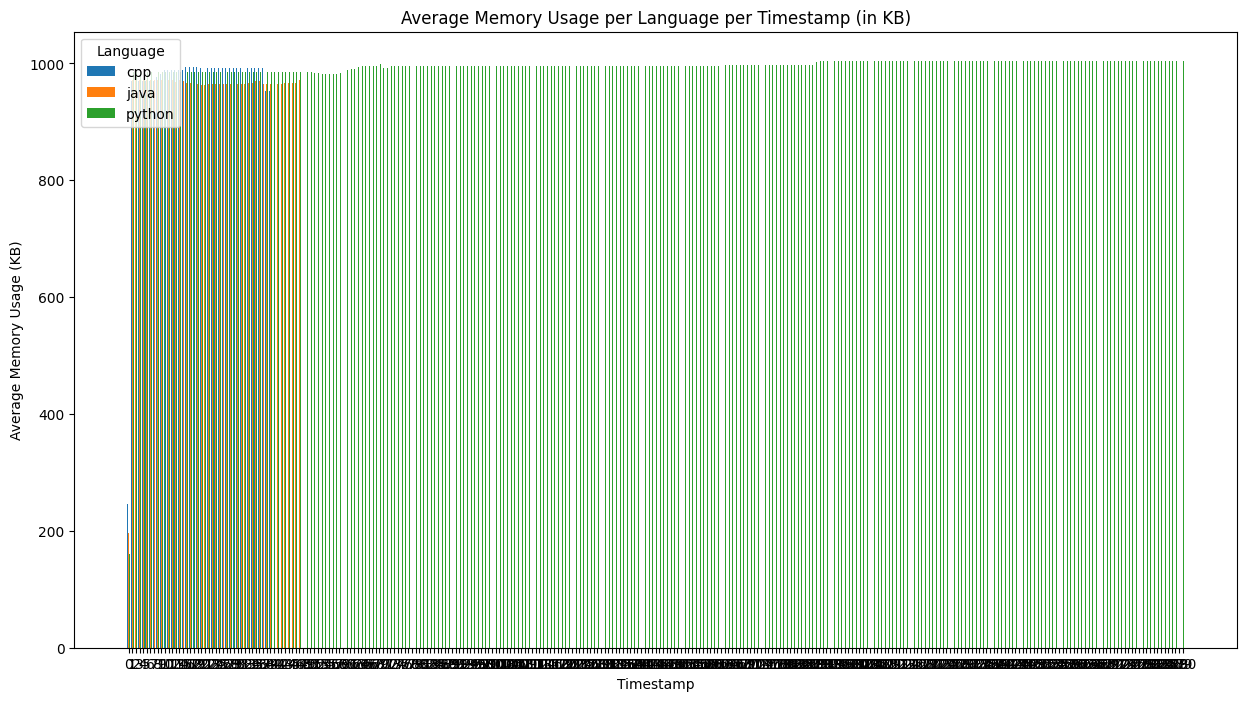

In [15]:
show_memory_usage(benchmark_rc_df)

## Lines of Code

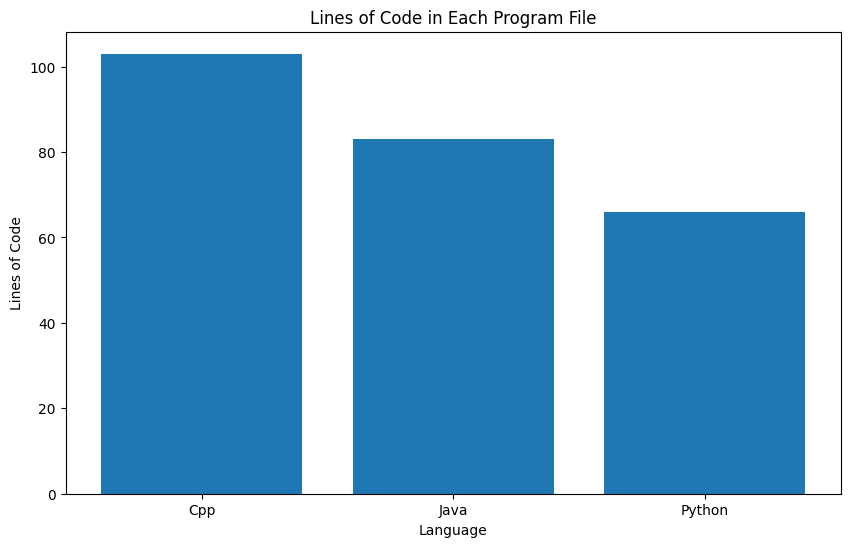

In [7]:
def count_lines_of_code(file_path):
    """Counts the number of lines in a given file."""
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        return "File not found."

lines_of_code = {
    'Cpp': count_lines_of_code("./cpp/merge_sort.cpp"),
    'Java': count_lines_of_code("./java/MergeSort.java"),
    'Python': count_lines_of_code("./python/merge_sort.py")
}

# Converting to a DataFrame for plotting
loc_df = pd.DataFrame(list(lines_of_code.items()), columns=['Language', 'Lines of Code'])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(loc_df['Language'], loc_df['Lines of Code'])
plt.title('Lines of Code in Each Program File')
plt.xlabel('Language')
plt.ylabel('Lines of Code')
plt.show()

## Characters

,Language,Characters Used
0,Cpp,2546
1,Java,2555
2,Python,1640


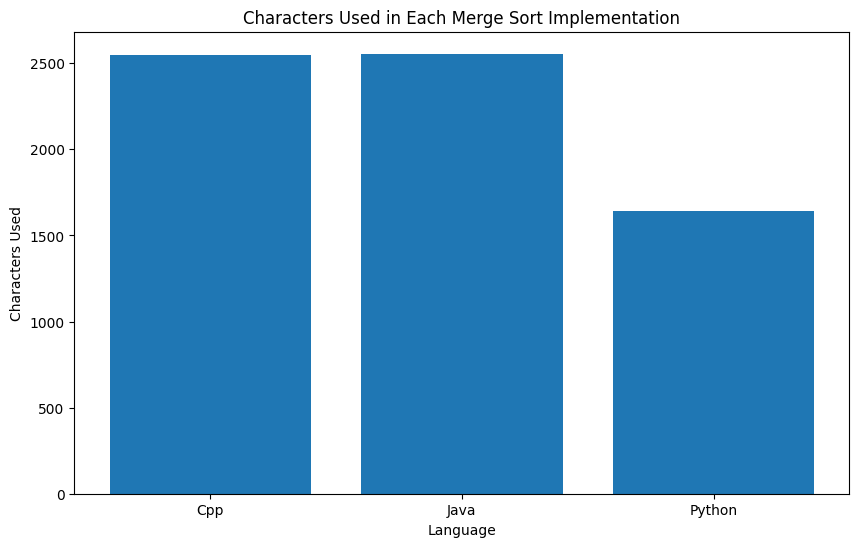

In [5]:
def count_characters(file_path):
    """Counts the number of characters in a given file."""
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            return len(content)
    except FileNotFoundError:
        return "File not found."

characters_used = {
    'Cpp': count_characters("./cpp/merge_sort.cpp"),
    'Java': count_characters("./java/MergeSort.java"),
    'Python': count_characters("./python/merge_sort.py")
}


chars_df = pd.DataFrame(list(characters_used.items()), columns=['Language', 'Characters Used'])

display(chars_df)

plt.figure(figsize=(10, 6))
plt.bar(chars_df['Language'], chars_df['Characters Used'])
plt.title('Characters Used in Each Merge Sort Implementation')
plt.xlabel('Language')
plt.ylabel('Characters Used')
plt.show()